In [1]:
import numpy as np

from scipy.signal import find_peaks, peak_prominences

from typing import Optional, Tuple, Dict

import plotly.graph_objects as go
import plotly.express as px
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, silhouette_score, silhouette_samples, confusion_matrix, ConfusionMatrixDisplay, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, cross_validate

from util import *
from plotting_util import *

color_dict = {
    'PP-pure': 'aqua', 
    'PP-yellow': 'yellow',
    'PP-green': 'chartreuse',
    'PP-orange': 'darkorange',
    'PP-pink': 'deeppink',
    'PP-yellow/green': 'greenyellow',
}

In [2]:
wavelengths = np.load("data/wavelengths.npy", allow_pickle=True)
laser_end = 460     # Startwavelength for peak search in spectra

In [3]:
spectra_dict = np.load("data/spectra_peaks_dict.npy", allow_pickle=True).item()
# Convert data to DataFrame
spectra_df = df_from_dict(spectra_dict, normalize=True)
# Load additional measurement data
spectra2_dict = np.load("data/spectra_peaks_dict_2.npy", allow_pickle=True).item()
spectra2_df = df_from_dict(spectra2_dict, normalize=True)   

X = pd.concat([spectra_df, spectra2_df])
X = X.rename(index={'PP-green': 'PP-yellow/green'}, level='class')
X = X.rename(index={'PP-yellow': 'PP-yellow/green'}, level='class')

y = X.index.get_level_values('class')

sample_keys = X.index.get_level_values('sample_key')

classes = y.unique().tolist()
class_count = y.value_counts().to_dict()
display(class_count)

{'PP-yellow/green': 160, 'PP-orange': 80, 'PP-pink': 80}

In [ ]:
# --- Load test data ---
test_dict = np.load('data/test_spectra_peaks_dict_3.npy', allow_pickle=True).item()
# Convert data to DataFrame
X_test = df_from_dict(test_dict, normalize=True)

X_test = X_test.rename(index={'PP-green': 'PP-yellow/green'}, level='class')
X_test = X_test.rename(index={'PP-yellow': 'PP-yellow/green'}, level='class')

y_test = X_test.index.get_level_values('class')

In [4]:
# --- Plotting parameters ---
markers = ["v", "s", "o", "^", "D", "P", "X", "*"]
marker_dict = {cls: markers[i % len(markers)] for i, cls in enumerate(classes)}
# Plotly symbol map
_marker_map = {'s':'square', 'o':'circle', '^':'triangle-up', 'D':'diamond','v':'triangle-down','P':'pentagon','X':'x','*':'star'}
symbol_map = {cls: _marker_map.get(marker_dict.get(cls, 'o'), 'circle') for cls in set(classes)}

markersize = 50

alpha_pts = 0.85

# Intensity-Ratio Method

In [6]:
# --- Classification for Intensity Ratio Method ---
I0 = np.argwhere(wavelengths >= 614.3)[0][0]    
I1 = np.argwhere(wavelengths >= 495.8)[0][0]
I2 = np.argwhere(wavelengths >= 580.1)[0][0]
I3 = np.argwhere(wavelengths >= 466.9)[0][0]

# Apply Intensity Ratio transformation to data
X_minmax = min_max_norm(X, wavelengths, laser_end)
X_int = intensity_ratio_transform(X_minmax, I0, I1, I2, I3)
X_int = pd.DataFrame(X_int, index=X.index, columns=['R1', 'R2'])

scatter_plot(X_int, 'R1', 'R2', symbol_map, color_dict, markersize=markersize, alpha=alpha_pts, y_log=True)

# Numerical Dimensionality Reduction

In [7]:
pca_components = 30
lda_components = 2
print(f"Number of PCA components: {pca_components}, Number of LDA components: {lda_components}")

pca_lda = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=pca_components)),
    ('lda', LDA(n_components=lda_components)),
])

ld_df = pd.DataFrame(pca_lda.fit_transform(X, X.index.get_level_values('class')), index=X.index)
ld_df = ld_df.rename(columns=lambda x: f'LD{x+1}')

scatter_plot(ld_df, 'LD1', 'LD2', symbol_map, color_dict, markersize=markersize, alpha=alpha_pts)

Number of PCA components: 30, Number of LDA components: 2


# Classification
- Measurement series 1 & 2 for Training
- Measurement series 3 for Testing

In [8]:
# Define classifier
clf = KNeighborsClassifier(n_neighbors=5, metric='euclidean', weights='distance')

,Score
Accuracy,1.0
Precision (macro),1.0
Recall (macro),1.0
F1 (macro),1.0
"ROC-AUC (ovr, micro)",1.0


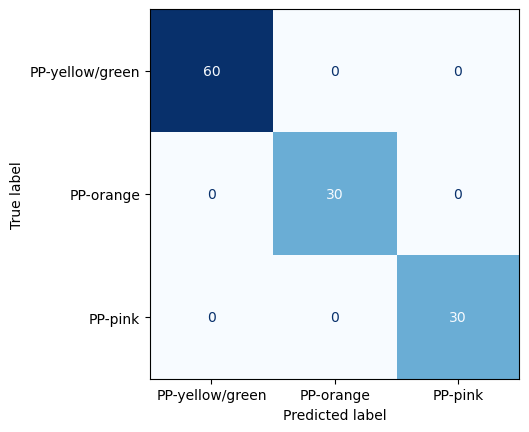

In [9]:
# --- Classification for PCA-LDA-Pipeline ---

# Apply PCA-LDA transformation to train data
pca_lda.fit(X, y)
X_train_trans = pca_lda.transform(X)
X_train_df = pd.DataFrame(X_train_trans, index=X.index, columns=[f'LD{i+1}' for i in range(lda_components)])

# Apply PCA-LDA transformation to test data
X_test_trans = pca_lda.transform(X_test)
X_test_df = pd.DataFrame(X_test_trans, index=X_test.index, columns=[f'LD{i+1}' for i in range(lda_components)])

# Evaluate classifier
metrics_df, pred, probs = evaluate_classifier(clf, X_train_df, X_test_df, y, y_test, classes, plot=True)
display(metrics_df)

scatter_plot_train_test(X_train_df, X_test_df, 'LD1', 'LD2', symbol_map, color_dict)

In [10]:
# --- Classification for Intensity-Ratio Method ---

# Apply Intensity Ratio transformation to train data
X_train_minmax = min_max_norm(X, wavelengths, laser_end)
X_train_trans = intensity_ratio_transform(X_train_minmax, I0, I1, I2, I3)
X_train_df = pd.DataFrame(X_train_trans, index=X.index, columns=['R1', 'R2'])

# Apply Intensity Ratio transformation to test data and make predictions
X_test_minmax = min_max_norm(X_test, wavelengths, laser_end)
X_test_trans = intensity_ratio_transform(X_test_minmax, I0, I1, I2, I3)
X_test_df = pd.DataFrame(X_test_trans, index=X_test.index, columns=['R1', 'R2'])

# Evaluate classifier
metrics_df, pred, probs = evaluate_classifier(clf, X_train_df, X_test_df, y, y_test, classes)
display(metrics_df)


scatter_plot_train_test(X_train_df, X_test_df, 'R1', 'R2', symbol_map, color_dict, y_log=True)

,Score
Accuracy,1.0
Precision (macro),1.0
Recall (macro),1.0
F1 (macro),1.0
"ROC-AUC (ovr, micro)",1.0


# Crossvalidation

In [11]:
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

In [12]:
# --- Numerical Cross-validation ---
metrics_df = pd.DataFrame()
missclassifications = np.zeros((len(classes), len(classes)), dtype=int)

for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Apply PCA-LDA transformation to train data
    pca_lda.fit(X_train, y_train)
    X_train_trans = pca_lda.transform(X_train)
    X_train_df = pd.DataFrame(X_train_trans, index=X_train.index, columns=[f'LD{i+1}' for i in range(lda_components)])

    # Apply PCA-LDA transformation to test data
    X_test_trans = pca_lda.transform(X_test)
    X_test_df = pd.DataFrame(X_test_trans, index=X_test.index, columns=[f'LD{i+1}' for i in range(lda_components)])

    # Evaluate classifier
    metrics, pred, probs = evaluate_classifier(clf, X_train_df, X_test_df, y_train, y_test, classes, plot=False)

    missclassifications += confusion_matrix(y_test, pred, labels=classes) - np.diag(np.diag(confusion_matrix(y_test, pred, labels=classes)))
    
    metrics_df = pd.concat([metrics_df, metrics], axis=1)

metrics_df.columns = [f'Fold {i+1}' for i in range(n_splits)]
metrics_df.insert(0, 'Mean', metrics_df.mean(axis=1))
display(metrics_df)
misclassified_df = pd.DataFrame(missclassifications, index=classes, columns=classes)
display(misclassified_df)

,Mean,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Fold 6,Fold 7,Fold 8,Fold 9,Fold 10
Accuracy,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Precision (macro),1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Recall (macro),1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
F1 (macro),1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
"ROC-AUC (ovr, micro)",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


,PP-yellow/green,PP-orange,PP-pink
PP-yellow/green,0,0,0
PP-orange,0,0,0
PP-pink,0,0,0


In [13]:
# --- Intensity-Ratio Cross-validation ---
metrics_df = pd.DataFrame()
missclassifications = np.zeros((len(classes), len(classes)), dtype=int)

for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Apply Intensity Ratio transformation to train data
    X_train_minmax = min_max_norm(X_train, wavelengths, laser_end)
    X_train_trans = intensity_ratio_transform(X_train_minmax, I0, I1, I2, I3)
    X_train_df = pd.DataFrame(X_train_trans, index=X_train.index, columns=['R1', 'R2'])

    # Apply Intensity Ratio transformation to test data and make predictions
    X_test_minmax = min_max_norm(X_test, wavelengths, laser_end)
    X_test_trans = intensity_ratio_transform(X_test_minmax, I0, I1, I2, I3)
    X_test_df = pd.DataFrame(X_test_trans, index=X_test.index, columns=['R1', 'R2'])

    # Evaluate classifier
    metrics, pred, probs = evaluate_classifier(clf, X_train_df, X_test_df, y_train, y_test, classes)
    
    missclassifications += confusion_matrix(y_test, pred, labels=classes) - np.diag(np.diag(confusion_matrix(y_test, pred, labels=classes)))
    
    metrics_df = pd.concat([metrics_df, metrics], axis=1)

metrics_df.columns = [f'Fold {i+1}' for i in range(n_splits)]
metrics_df.insert(0, 'Mean', metrics_df.mean(axis=1))
display(metrics_df)
misclassified_df = pd.DataFrame(missclassifications, index=classes, columns=classes)
display(misclassified_df)

,Mean,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Fold 6,Fold 7,Fold 8,Fold 9,Fold 10
Accuracy,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Precision (macro),1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Recall (macro),1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
F1 (macro),1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
"ROC-AUC (ovr, micro)",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


,PP-yellow/green,PP-orange,PP-pink
PP-yellow/green,0,0,0
PP-orange,0,0,0
PP-pink,0,0,0
